## Imports

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from src.data_loader import load_ravdess_data, load_audio_file
from src.feature_extraction import *
from src.config import *

## Load Dataset

In [2]:
df = load_ravdess_data()
print(f"Total feature vector size: {get_feature_vector_size()}")

Loaded 2880 audio files

Emotion distribution:
emotion
calm         384
happy        384
sad          384
angry        384
disgust      384
fear         384
surprised    384
neutral      192
Name: count, dtype: int64
Total feature vector size: 382


## Sample Feature Extraction

In [3]:
sample = df.iloc[0]
print(f"Sample file: {sample["filename"]}")
print(f"Emotion: {sample["emotion"]}")

audio = load_audio_file(sample["file_path"])

# Extract features
mfcc_features = extract_mfcc(audio)
mel_features = extract_mel_spectrogram(audio)
chroma_features = extract_chroma(audio)
zcr_features = extract_zero_crossing_rate(audio)
spectral_features = extract_spectral_features(audio)
rms_features = extract_rms_energy(audio)

print(f"\nMFCC features shape: {mfcc_features.shape}")
print(f"Mel spectrogram features shape: {mel_features.shape}")
print(f"Chroma features shape: {chroma_features.shape}")
print(f"ZCR features shape: {zcr_features.shape}")
print(f"Spectral features shape: {spectral_features.shape}")
print(f"RMS features shape: {rms_features.shape}")

all_features = extract_all_features(audio)
print(f"\nCombined feature vector shape: {all_features.shape}")

Sample file: 03-01-01-01-01-01-01.wav
Emotion: neutral

MFCC features shape: (80,)
Mel spectrogram features shape: (256,)
Chroma features shape: (24,)
ZCR features shape: (2,)
Spectral features shape: (18,)
RMS features shape: (2,)

Combined feature vector shape: (382,)


## Visualization

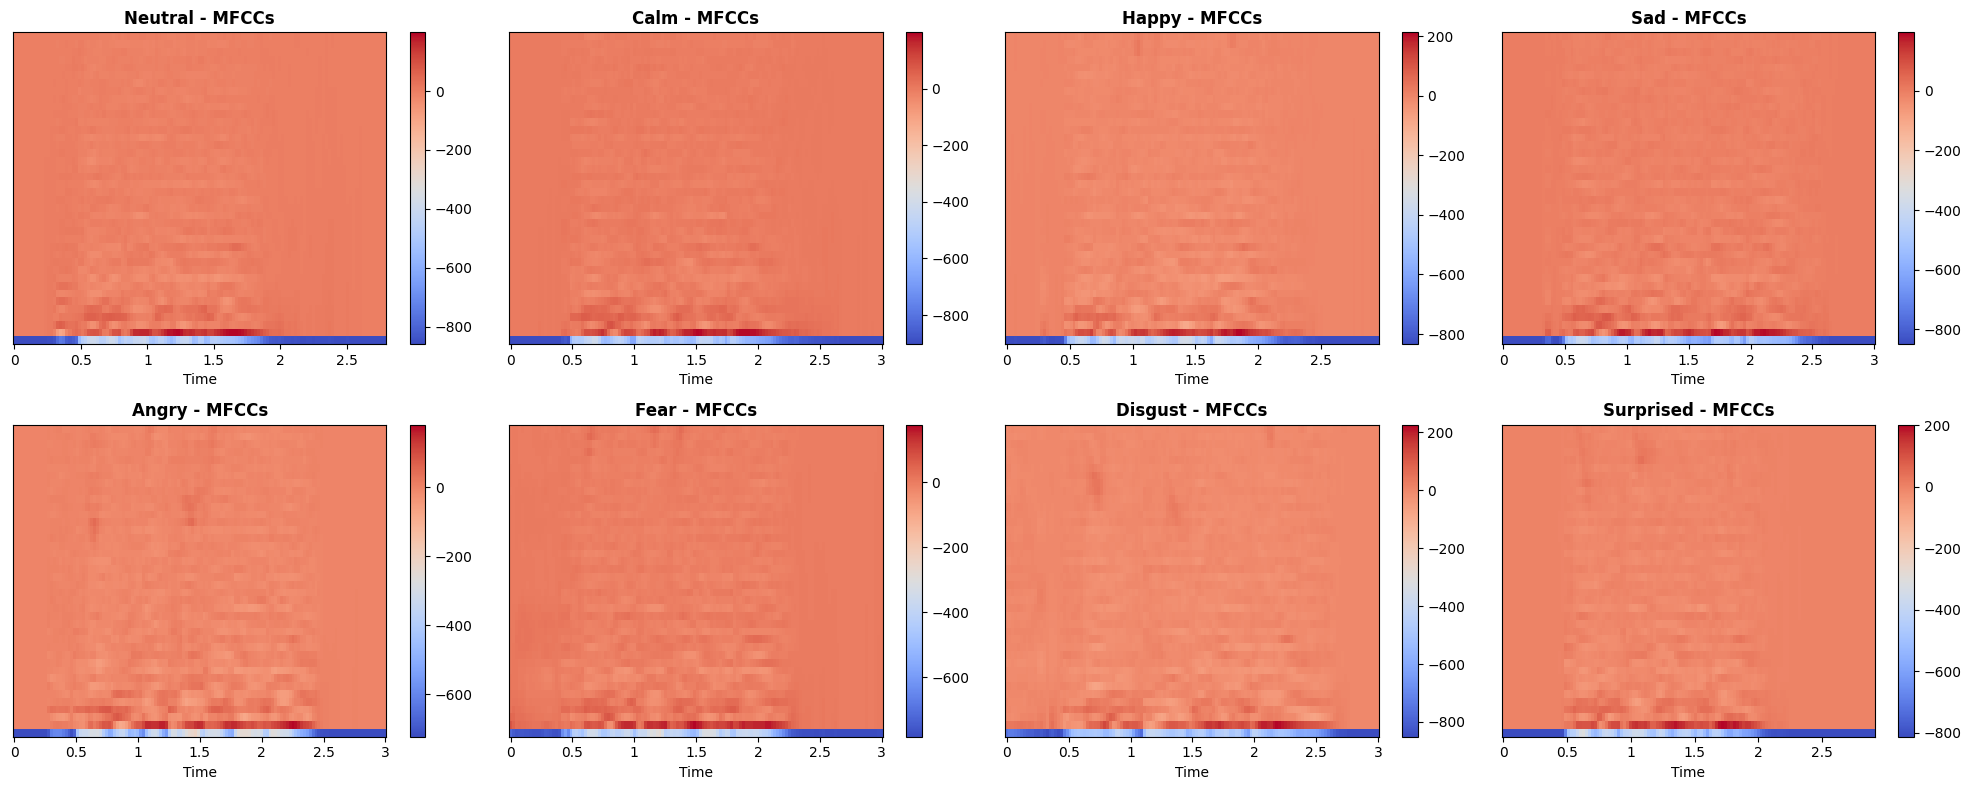

In [4]:
# MFCC features for different emotions
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.ravel()

for i, emotion in enumerate(df["emotion"].unique()):
    sample = df[df["emotion"] == emotion].iloc[0]
    audio = load_audio_file(sample["file_path"])
    
    if audio is not None:
        mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
        img = librosa.display.specshow(mfccs, sr=SAMPLE_RATE, x_axis="time", ax=axes[i])
        axes[i].set_title(f"{emotion.capitalize()} - MFCCs", fontweight="bold")
        fig.colorbar(img, ax=axes[i])

plt.tight_layout()
plt.show()

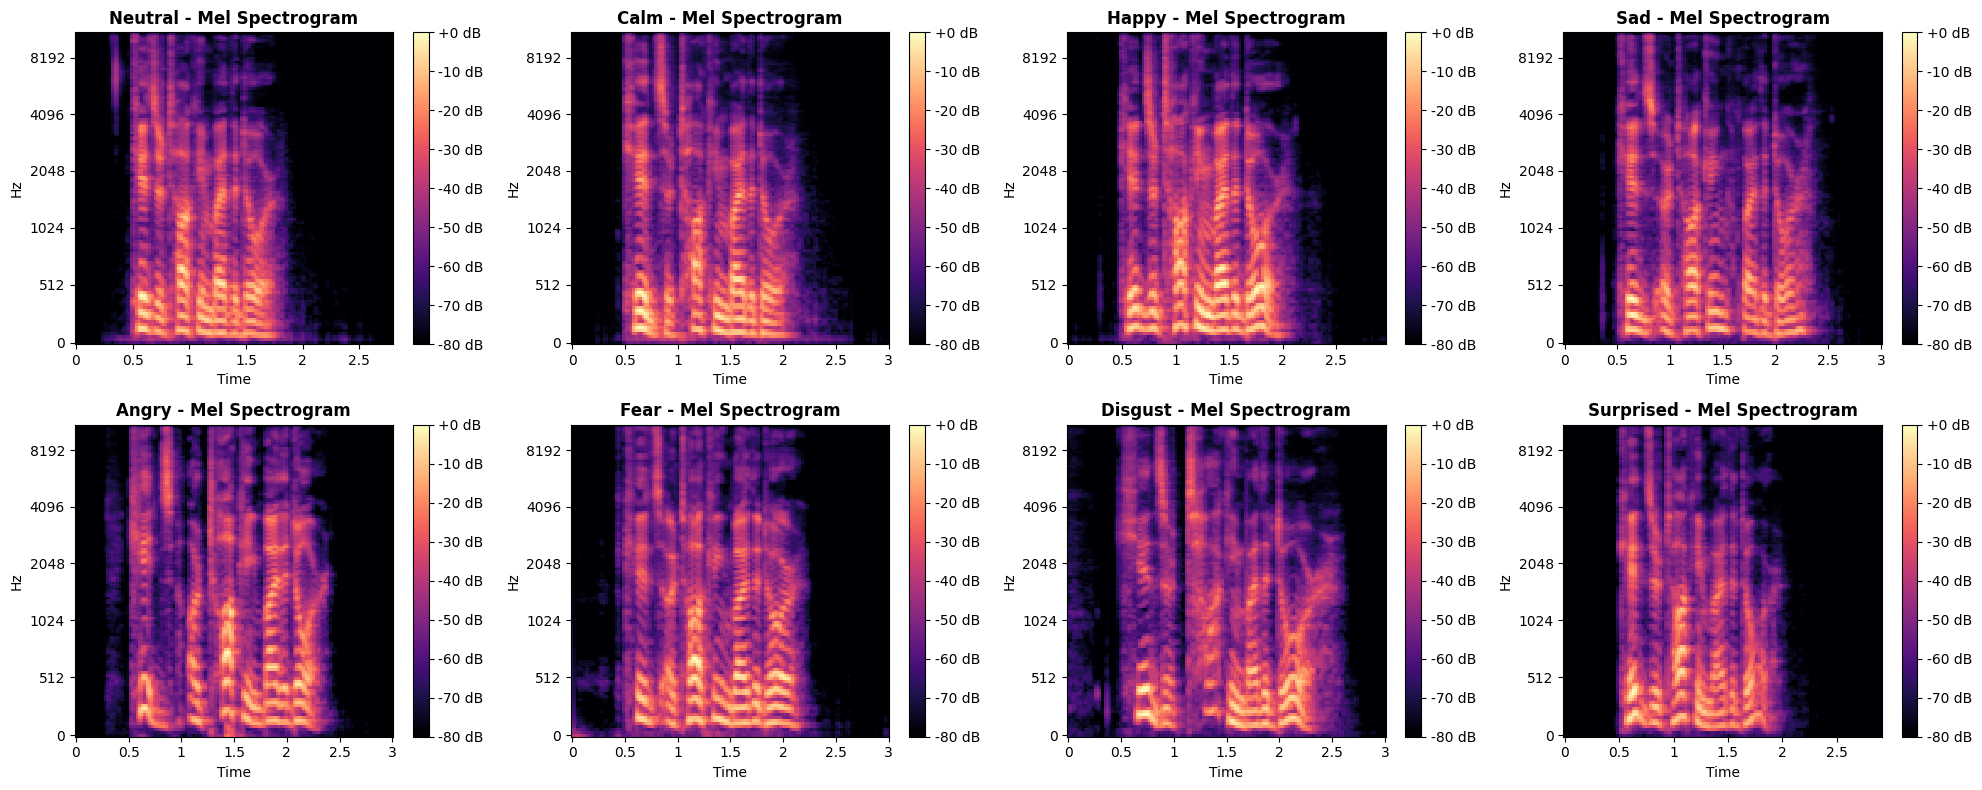

In [5]:
# Mel spectrogram for different emotions
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.ravel()

for i, emotion in enumerate(df["emotion"].unique()):
    sample = df[df["emotion"] == emotion].iloc[0]
    audio = load_audio_file(sample["file_path"])
    
    if audio is not None:
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = librosa.display.specshow(mel_spec_db, sr=SAMPLE_RATE, x_axis="time", 
                                       y_axis="mel", ax=axes[i])
        axes[i].set_title(f"{emotion.capitalize()} - Mel Spectrogram", fontweight="bold")
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")

plt.tight_layout()
plt.show()

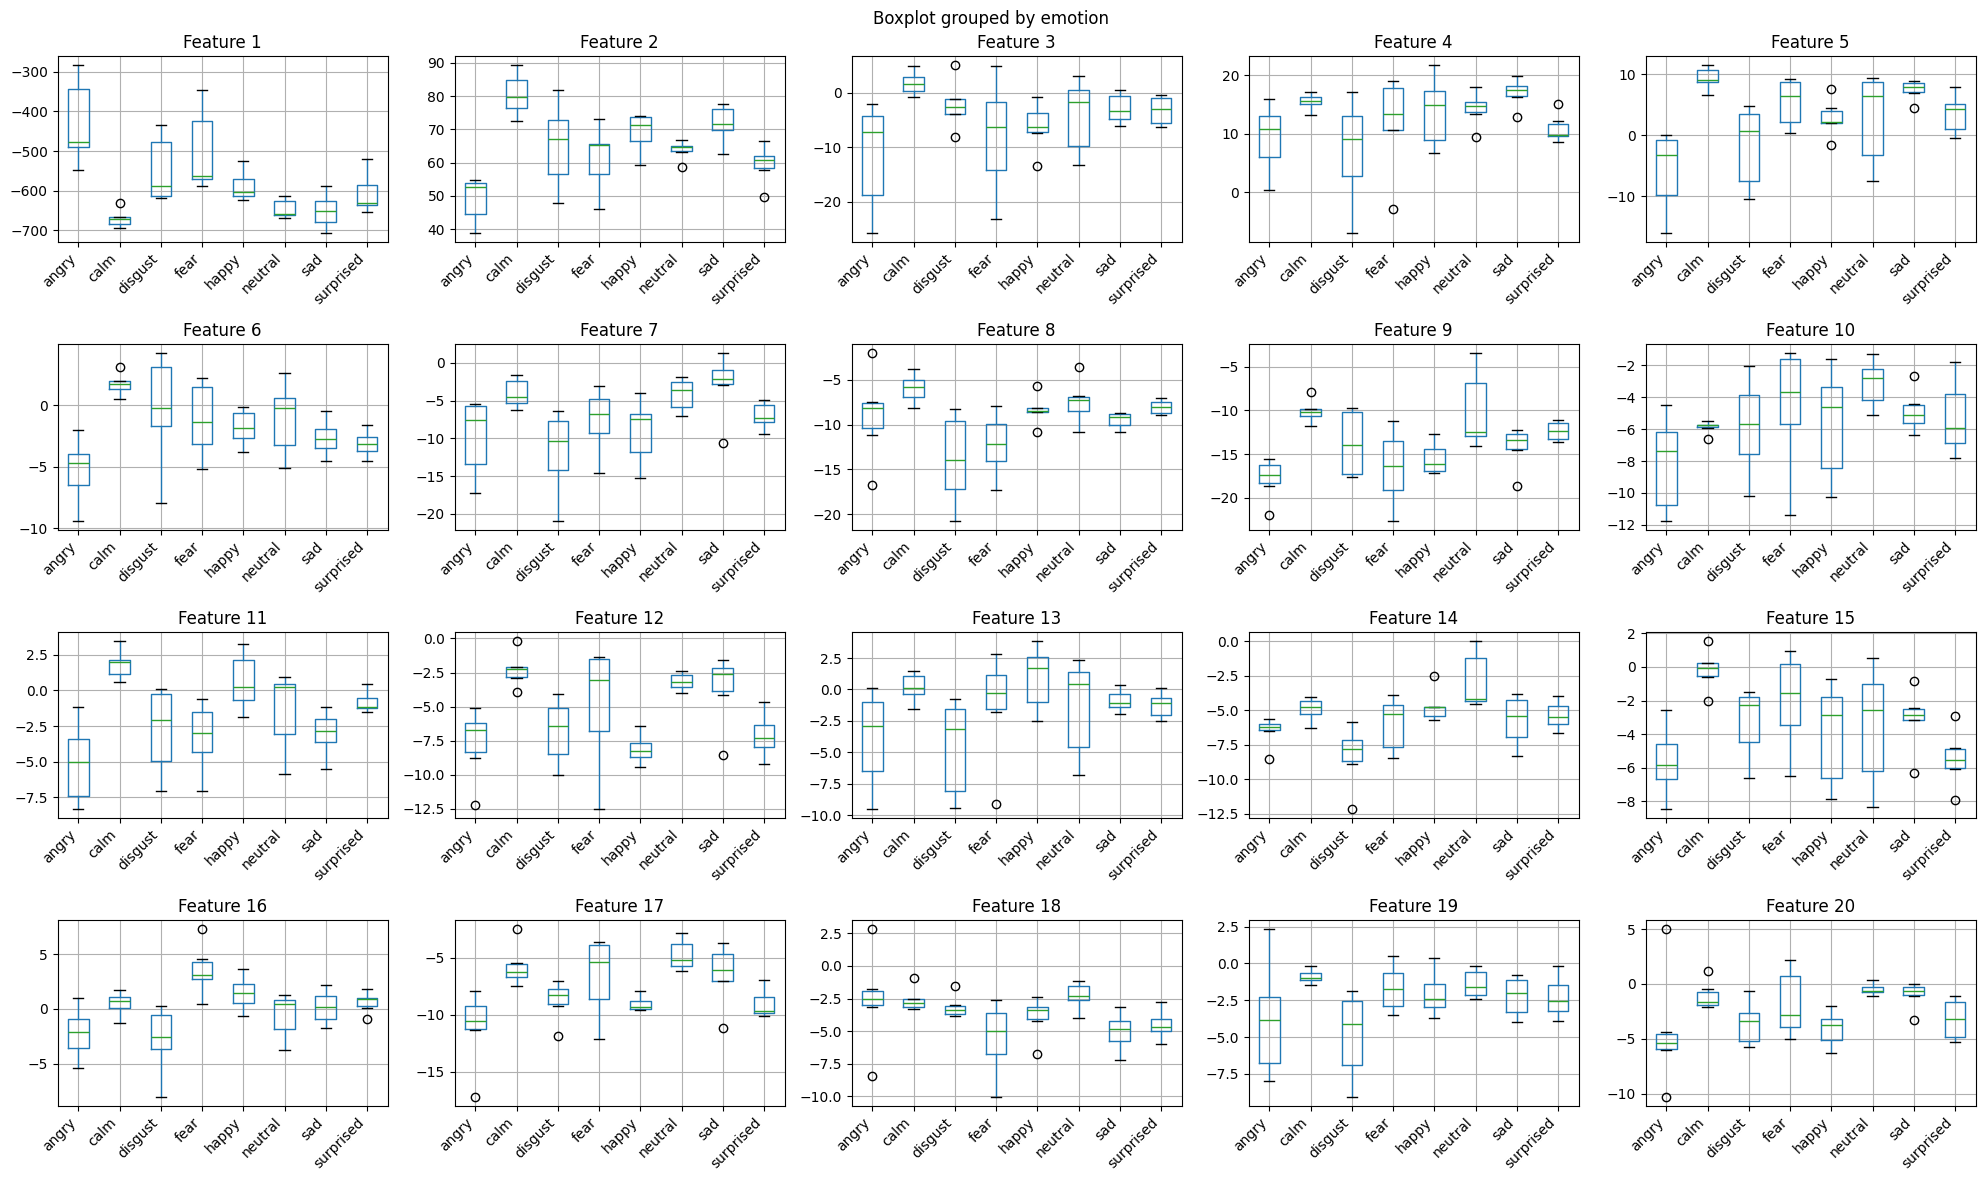

In [6]:
# Feature distributions by emotions
sample_size = 50
sample_df = df.groupby("emotion").head(sample_size // 8)

feature_data = []
for idx, row in sample_df.iterrows():
    audio = load_audio_file(row["file_path"])
    if audio is not None:
        features = extract_all_features(audio)
        feature_data.append({
            "emotion": row["emotion"],
            "features": features
        })

feature_df = pd.DataFrame(feature_data)

# Feature distributions
n_features = 20
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.ravel()

for i in range(n_features):
    feature_values = np.array([f[i] for f in feature_df["features"]])
    emotions = feature_df["emotion"]
    
    # Create box plot
    data_for_plot = pd.DataFrame({"value": feature_values, "emotion": emotions})
    data_for_plot.boxplot(by="emotion", column="value", ax=axes[i])
    axes[i].set_title(f"Feature {i+1}")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)
    plt.sca(axes[i])
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Feature Correlation Analysis

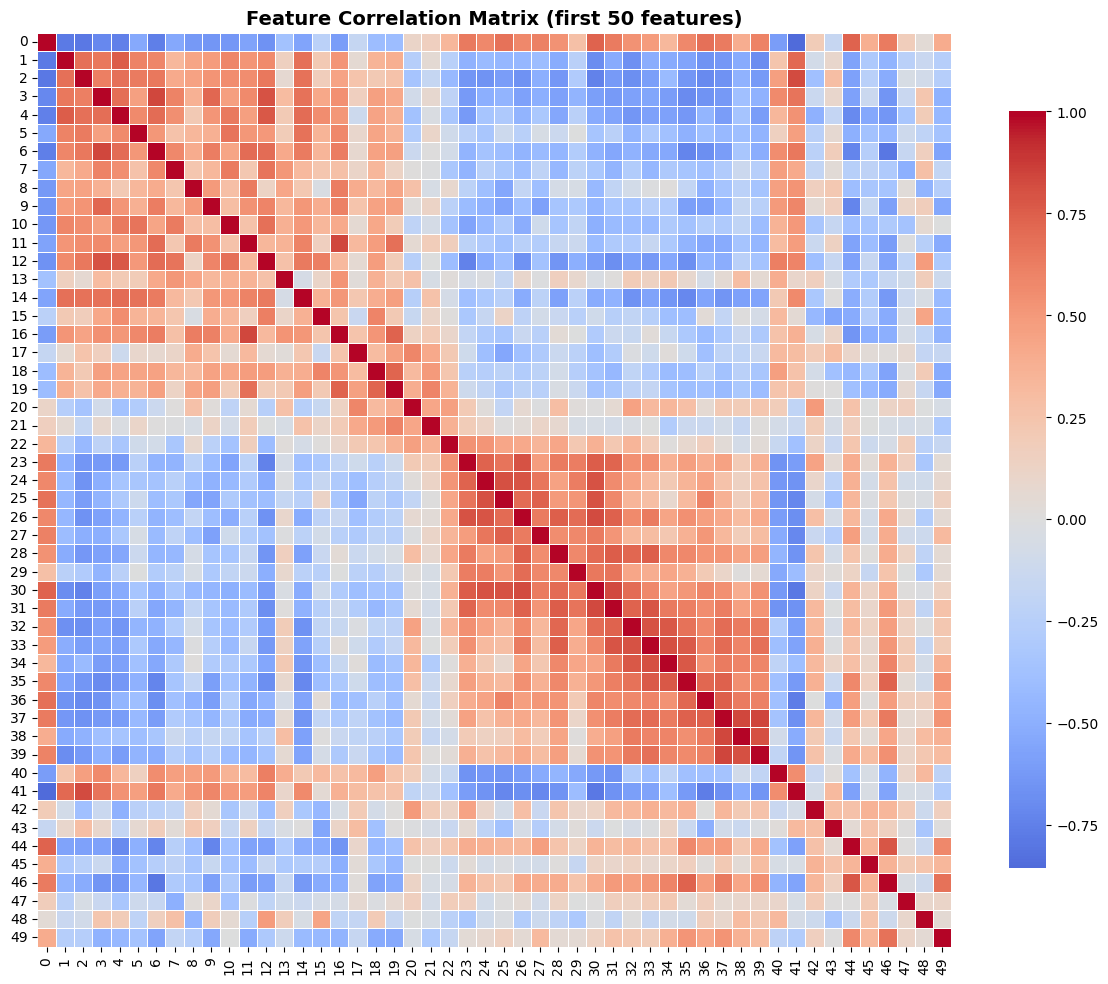

In [ ]:
n_features = 50 # num of features to show
feature_matrix = np.array([f for f in feature_df["features"]])
feature_names = [f"F{i}" for i in range(feature_matrix.shape[1])]

# Compute correlation matrix
correlation_matrix = np.corrcoef(feature_matrix[:, :n_features].T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f"Feature Correlation Matrix (first {n_features} features)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()